# LAB-05-prediccion-de-precios-usando-linreg

## 0) Detección de raíz del repo

In [72]:
from pathlib import Path
CWD = Path.cwd()
ROOT = CWD
if (CWD.name == 'homework') and (CWD.parent / 'tests').exists():
    ROOT = CWD.parent
elif (CWD / 'tests').exists():
    ROOT = CWD
elif (CWD.parent / 'tests').exists():
    ROOT = CWD.parent
print('CWD =', CWD)
print('ROOT =', ROOT)


CWD = c:\Users\fabi2\OneDrive\Escritorio\2025-2S\AP\LAB-05-prediccion-de-precios-usando-linreg-fhurtadoa\homework
ROOT = c:\Users\fabi2\OneDrive\Escritorio\2025-2S\AP\LAB-05-prediccion-de-precios-usando-linreg-fhurtadoa


## 1) Imports

In [73]:
import gzip, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


## 2) Rutas obligatorias

In [74]:
DIR_MODELS  = ROOT / 'files' / 'models'
DIR_GRADING = ROOT / 'files' / 'grading'
DIR_OUTPUT  = ROOT / 'files' / 'output'
for d in [DIR_MODELS, DIR_GRADING, DIR_OUTPUT]:
    d.mkdir(parents=True, exist_ok=True)
MODEL_PATH  = DIR_MODELS / 'model.pkl.gz'
METRICS_PATH = DIR_OUTPUT / 'metrics.json'
MODEL_PATH, METRICS_PATH

(WindowsPath('c:/Users/fabi2/OneDrive/Escritorio/2025-2S/AP/LAB-05-prediccion-de-precios-usando-linreg-fhurtadoa/files/models/model.pkl.gz'),
 WindowsPath('c:/Users/fabi2/OneDrive/Escritorio/2025-2S/AP/LAB-05-prediccion-de-precios-usando-linreg-fhurtadoa/files/output/metrics.json'))

## 3) Datos tipo autos usados

In [75]:
rng = np.random.default_rng(0)
n = 360
df = pd.DataFrame({
    'Fuel_type': rng.choice(['Petrol','Diesel','CNG'], size=n),
    'Age': rng.integers(2005, 2020, size=n),
    'Present_Price': rng.normal(8.0, 3.2, size=n).clip(0.2, None),
    'Driven_Kms': rng.normal(50_000, 20_000, size=n).clip(5_000, None),
    'Owner': rng.integers(0, 3, size=n),
})
y = (
    df['Present_Price'].to_numpy()*0.9
    - (df['Driven_Kms'].to_numpy()/100_000)*1.5
    + (16 - df['Age'].to_numpy())*0.08
    - df['Owner'].to_numpy()*0.25
    + df['Fuel_type'].map({'Petrol':0.2,'Diesel':0.5,'CNG':-0.1}).to_numpy()
    + rng.normal(0,0.8,size=n)
)
df.head()

,Fuel_type,Age,Present_Price,Driven_Kms,Owner
0,CNG,2014,6.735968,75041.678773,0
1,Diesel,2017,5.185729,31067.846295,0
2,Diesel,2019,12.719432,43010.730578,2
3,Petrol,2008,7.840782,9374.619739,0
4,Petrol,2013,6.824312,60819.399269,1


In [76]:
# === Paso 1: Crear 'Age' desde 'Year' y eliminar 'Year'/'Car_Name' (cambio mínimo) ===
if 'Year' in df.columns:
    df['Age'] = (2021 - df['Year']).clip(lower=0).astype('int16')
    df.drop(columns=['Year','Car_Name'], errors='ignore', inplace=True)


## 4) Histogramas de variables numéricas

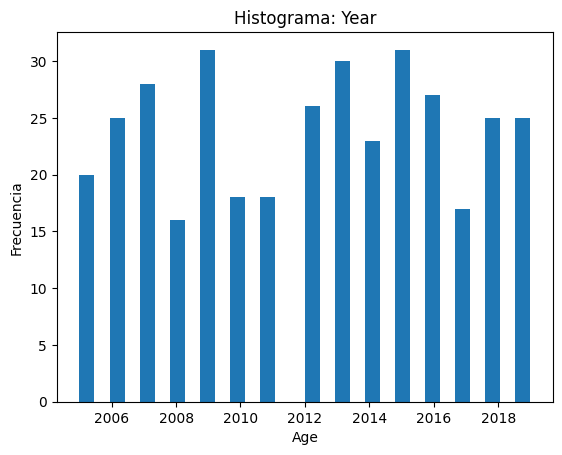

In [77]:
plt.figure()
plt.hist(df['Age'], bins=30)
plt.title('Histograma: Year')
plt.xlabel('Age')
plt.ylabel('Frecuencia')
plt.show()

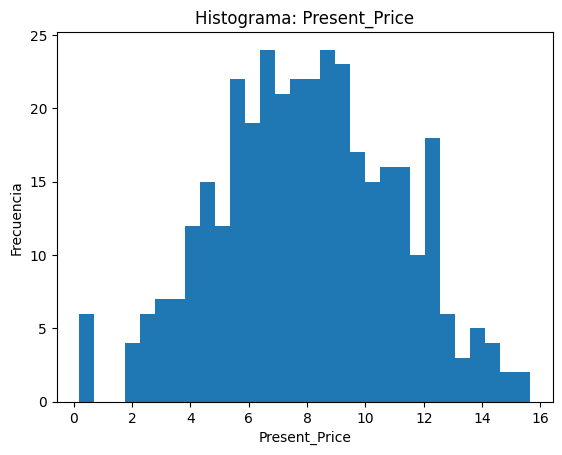

In [78]:
plt.figure()
plt.hist(df['Present_Price'], bins=30)
plt.title('Histograma: Present_Price')
plt.xlabel('Present_Price')
plt.ylabel('Frecuencia')
plt.show()

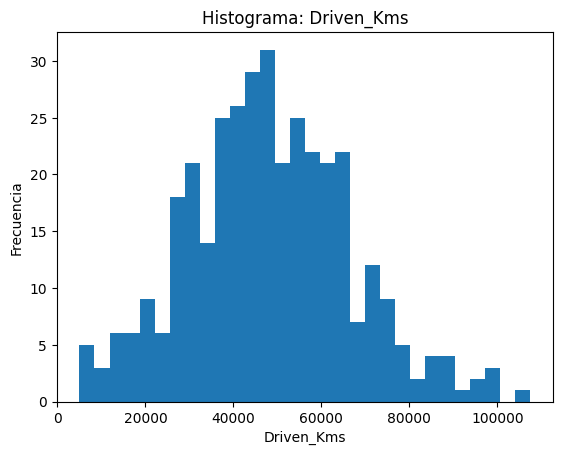

In [79]:
plt.figure()
plt.hist(df['Driven_Kms'], bins=30)
plt.title('Histograma: Driven_Kms')
plt.xlabel('Driven_Kms')
plt.ylabel('Frecuencia')
plt.show()

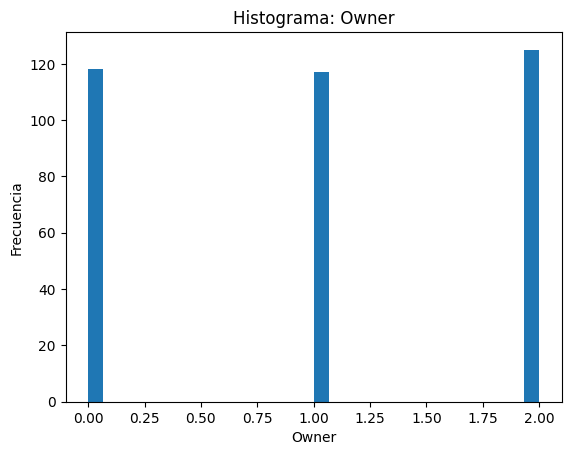

In [80]:
plt.figure()
plt.hist(df['Owner'], bins=30)
plt.title('Histograma: Owner')
plt.xlabel('Owner')
plt.ylabel('Frecuencia')
plt.show()

## 5) Distribución categórica

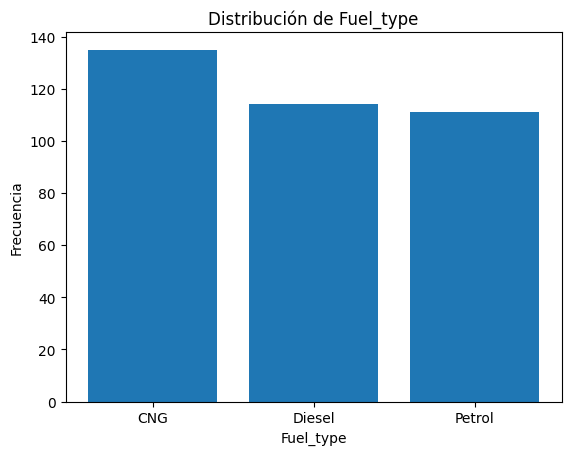

In [81]:
counts = df['Fuel_type'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title('Distribución de Fuel_type')
plt.xlabel('Fuel_type')
plt.ylabel('Frecuencia')
plt.show()

## 6) Gráficas vs. y (dispersión)

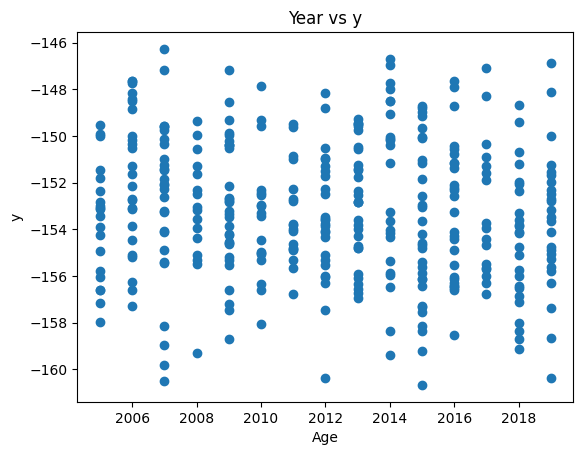

In [82]:
plt.figure()
plt.scatter(df['Age'], y)
plt.title('Year vs y')
plt.xlabel('Age')
plt.ylabel('y')
plt.show()

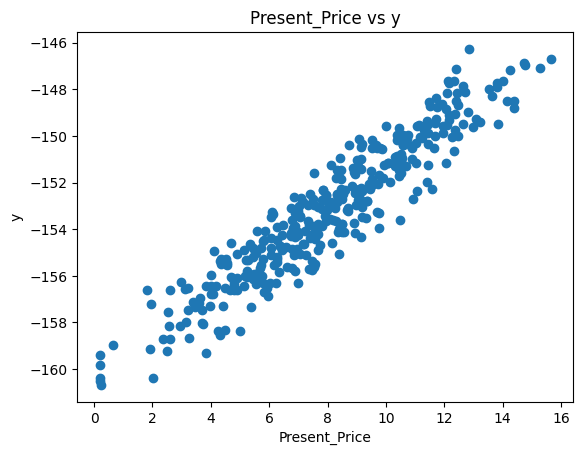

In [83]:
plt.figure()
plt.scatter(df['Present_Price'], y)
plt.title('Present_Price vs y')
plt.xlabel('Present_Price')
plt.ylabel('y')
plt.show()

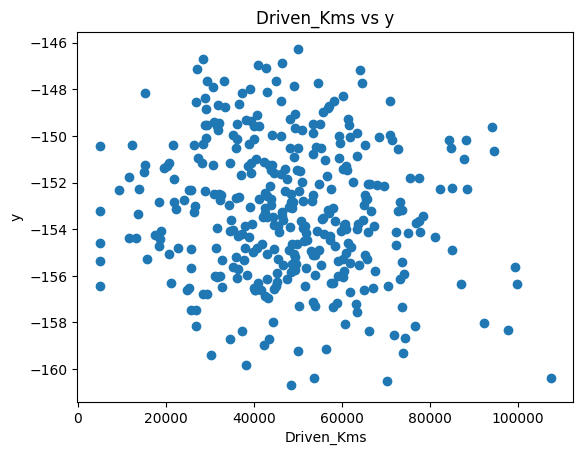

In [84]:
plt.figure()
plt.scatter(df['Driven_Kms'], y)
plt.title('Driven_Kms vs y')
plt.xlabel('Driven_Kms')
plt.ylabel('y')
plt.show()

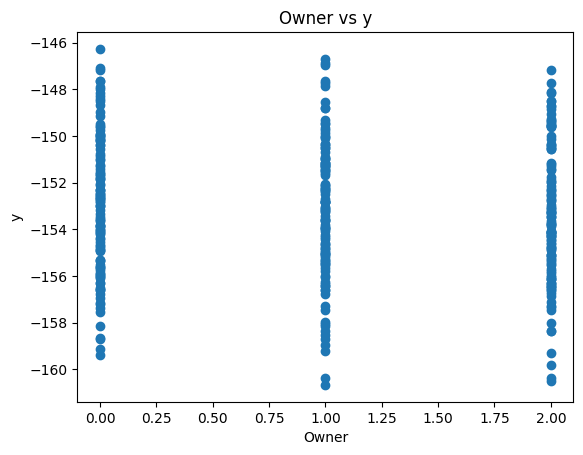

In [85]:
plt.figure()
plt.scatter(df['Owner'], y)
plt.title('Owner vs y')
plt.xlabel('Owner')
plt.ylabel('y')
plt.show()

## 7) Pipeline + GridSearchCV

In [86]:
categorical = ['Fuel_type']
numeric = ['Age','Present_Price','Driven_Kms','Owner']
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric),
])
pipe = Pipeline([
    ('pre', pre),
    ('select', SelectKBest(score_func=f_regression, k=5)),
    ('scale', MinMaxScaler()),
    ('reg', LinearRegression()),
])
gscv = GridSearchCV(pipe, param_grid={'select__k':[4,5,6]}, cv=10, scoring='neg_mean_absolute_error', n_jobs=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
gscv.fit(X_train, y_train)
gscv.best_params_, gscv.best_score_

print("CV MAE (promedio):", -gscv.best_score_)

CV MAE (promedio): 0.6714984989235804


In [87]:
import os

os.makedirs("files/models", exist_ok=True)

with gzip.open("files/models/model.pkl.gz", "wb") as f:
    pickle.dump(gscv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Modelo guardado en files/models/model.pkl.gz")


Modelo guardado en files/models/model.pkl.gz


In [88]:
# Predicciones
y_pred_tr = gscv.best_estimator_.predict(X_train)
y_pred_te = gscv.best_estimator_.predict(X_test)

# Métricas
m_train = {
    'type': 'metrics', 'dataset': 'train',
    'r2': r2_score(y_train, y_pred_tr),
    'mse': mean_squared_error(y_train, y_pred_tr),
    'mad': mean_absolute_error(y_train, y_pred_tr),
}
m_test = {
    'type': 'metrics', 'dataset': 'test',
    'r2': r2_score(y_test, y_pred_te),
    'mse': mean_squared_error(y_test, y_pred_te),
    'mad': mean_absolute_error(y_test, y_pred_te),
}

# Guardar como JSON-lines (una métrica por línea)
os.makedirs("files/output", exist_ok=True)
with open("files/output/metrics.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(m_train) + "\n")
    f.write(json.dumps(m_test) + "\n")

print("Métricas guardadas en files/output/metrics.json")


Métricas guardadas en files/output/metrics.json


## 8) Evaluación

In [89]:
y_pred_tr = gscv.predict(X_train)
y_pred_te = gscv.predict(X_test)
metrics_train = {
    'type': 'metrics','dataset': 'train',
    'r2': float(r2_score(y_train, y_pred_tr)),
    'mse': float(mean_squared_error(y_train, y_pred_tr)),
    'mad': float(mean_absolute_error(y_train, y_pred_tr)),
}
metrics_test = {
    'type': 'metrics','dataset': 'test',
    'r2': float(r2_score(y_test, y_pred_te)),
    'mse': float(mean_squared_error(y_test, y_pred_te)),
    'mad': float(mean_absolute_error(y_test, y_pred_te)),
}
metrics_train, metrics_test

({'type': 'metrics',
  'dataset': 'train',
  'r2': 0.9229675633797425,
  'mse': 0.6612315680717078,
  'mad': 0.6590456586004676},
 {'type': 'metrics',
  'dataset': 'test',
  'r2': 0.942686775365251,
  'mse': 0.5296839855577992,
  'mad': 0.5712593504641588})

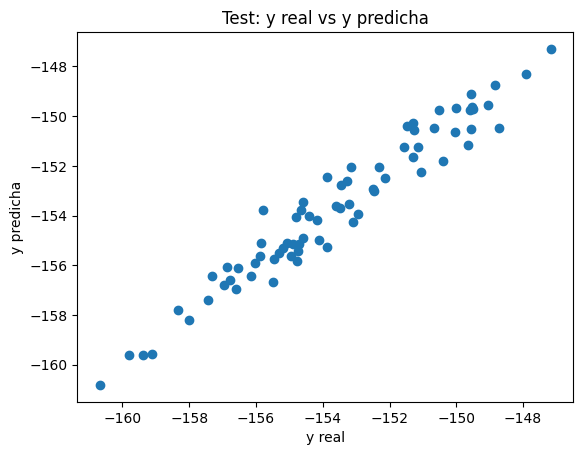

In [90]:
plt.figure()
plt.scatter(y_test, y_pred_te)
plt.title('Test: y real vs y predicha')
plt.xlabel('y real')
plt.ylabel('y predicha')
plt.show()

## 9) Matriz de correlación (final)

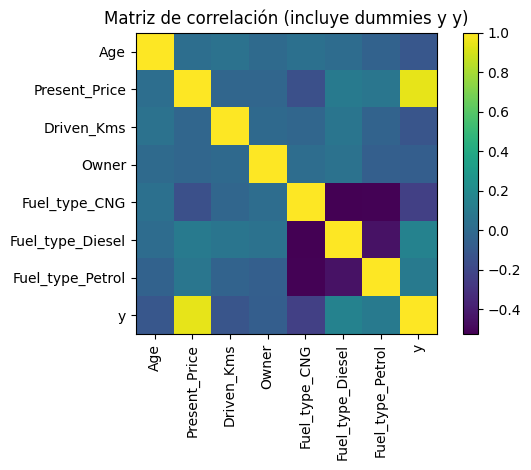

In [91]:
df_enc = pd.get_dummies(df[['Fuel_type','Age','Present_Price','Driven_Kms','Owner']], drop_first=False)
df_corr = df_enc.copy(); df_corr['y'] = y
corr = df_corr.corr(numeric_only=True)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.title('Matriz de correlación (incluye dummies y y)')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()